<a href="https://colab.research.google.com/github/maxi2321/MAXIABDALA/blob/main/final9_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install scipy==1.13.1

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Lectura de datos y creación de los espectrogramas

In [8]:
os.chdir('/content/drive/MyDrive/videos/')

In [9]:
# vemos los archivos de audio
data_folder = os.path.join( 'train')  # carpeta del training set
classes_folders = os.listdir(data_folder)                   # carpeta de cada clase

# Creamos un diccionario para cada clase donde pondremos los audios
data = {}
for c in classes_folders:
    if c[0] != '.':
        data[c] = data.get(c, []) # agregamos

# Llenamos una lista para cada clase con los datos
for c in classes_folders:
    if c[0] != '.':
        for f in os.listdir(os.path.join(data_folder, c)):
            path = os.path.join(data_folder, c, f)
            audio, sr = librosa.load(os.path.join(data_folder, c, f) , sr=None)  # leemos el audio como numpy array
            data[c].append(audio)   # no guardamos el samplerate porque todos son iguales

# Inspección de los datos

for k in data.keys():
    print(f'La clase {k} tiene {len(data[k])} elementos')

La clase colectivo tiene 12 elementos
La clase camioneta tiene 16 elementos
La clase moto tiene 6 elementos
La clase auto tiene 29 elementos
La clase silencio tiene 34 elementos


In [208]:
print(sr)

48000


In [209]:
# Tasa de muestreo que vamos a asumir para todos los audios


def compute_mel_spectrogram(audio_array, sampling_rate, n_fft=2048, hop_length=None, n_mels=512, desired_time_frames=400):

    """
    Compute STFT Spectrogram for a given audio array.

    Args:
    - audio_array (np.ndarray): Array containing audio data.
    - sr (int): Sampling rate of the audio file.

    Returns:
    - S_DB (np.ndarray): STFT spectrogram in decibels.
    """
    S = librosa.feature.melspectrogram(y=audio_array, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    return S_DB

# Diccionario para almacenar los espectrogramas STFT
stft_spectrograms = {}

# Calcular los espectrogramas STFT para cada clase y cada archivo de audio
for k, v in data.items():
    stft_spectrograms[k] = []
    for audio_array in v:
        stft_spec = compute_stft_spectrogram(audio_array, sampling_rate)
        stft_spectrograms[k].append(stft_spec)

# Verificar la cantidad de espectrogramas calculados por clase
for k, v in stft_spectrograms.items():
    print(f'Clase {k}: {len(v)} espectrogramas STFT')

Clase colectivo: 12 espectrogramas STFT
Clase camioneta: 16 espectrogramas STFT
Clase moto: 6 espectrogramas STFT
Clase auto: 29 espectrogramas STFT
Clase silencio: 34 espectrogramas STFT


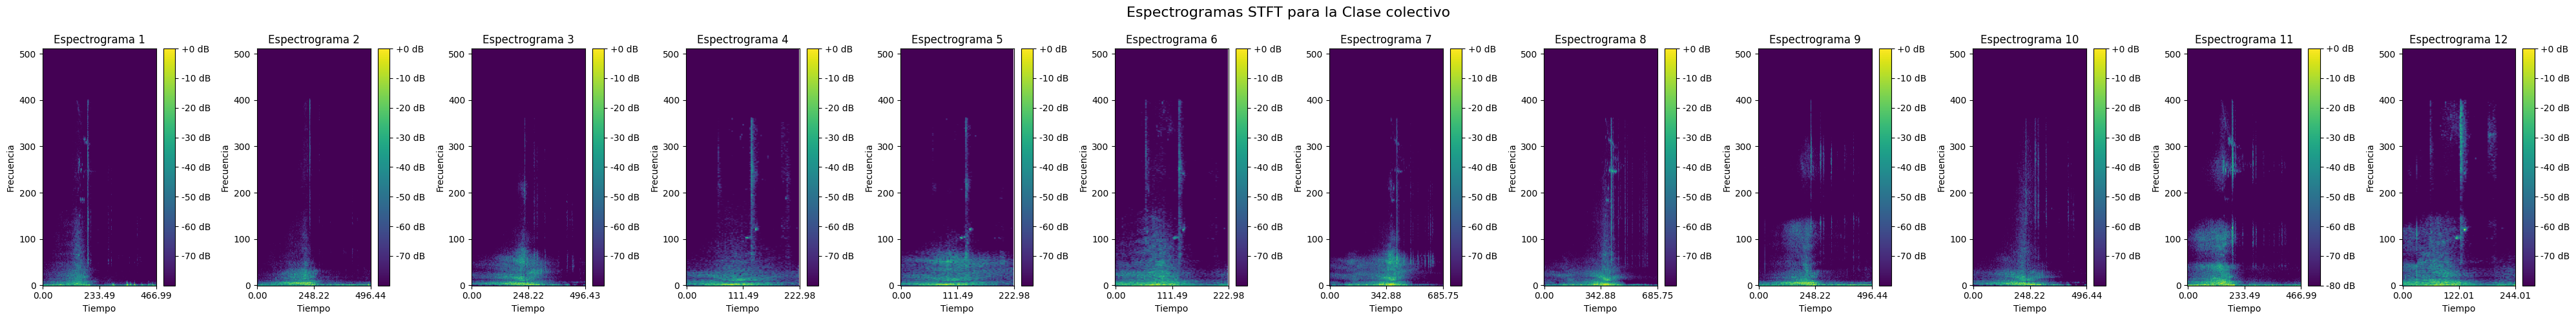

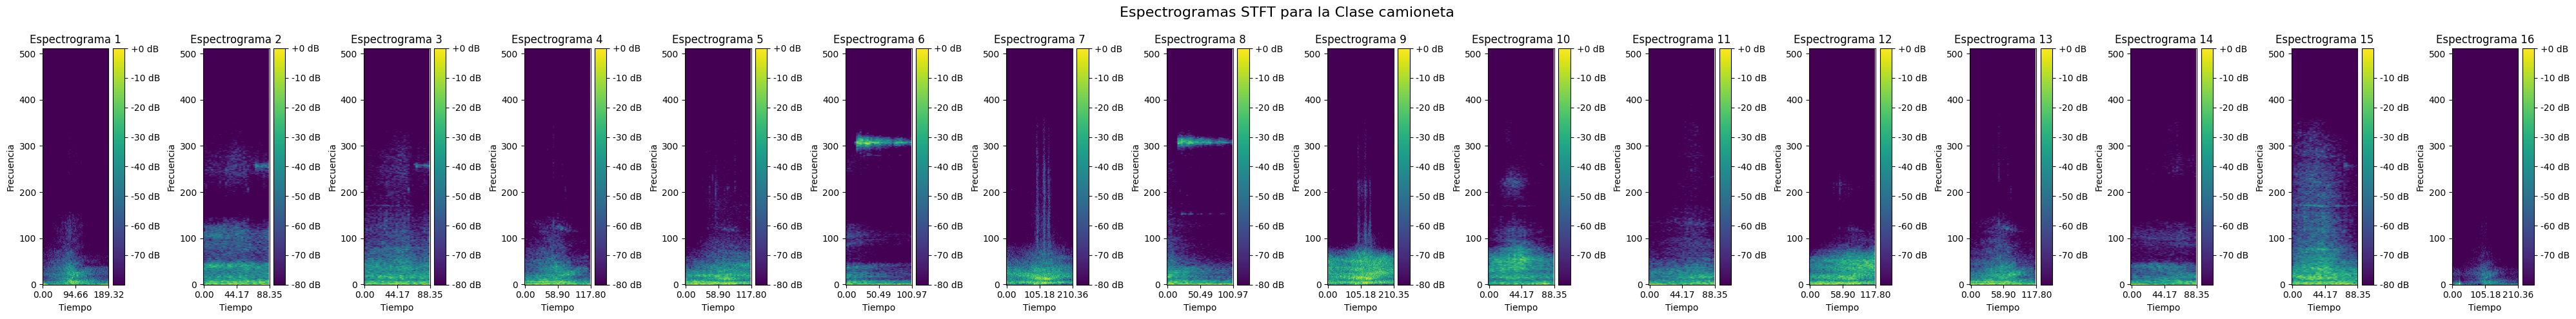

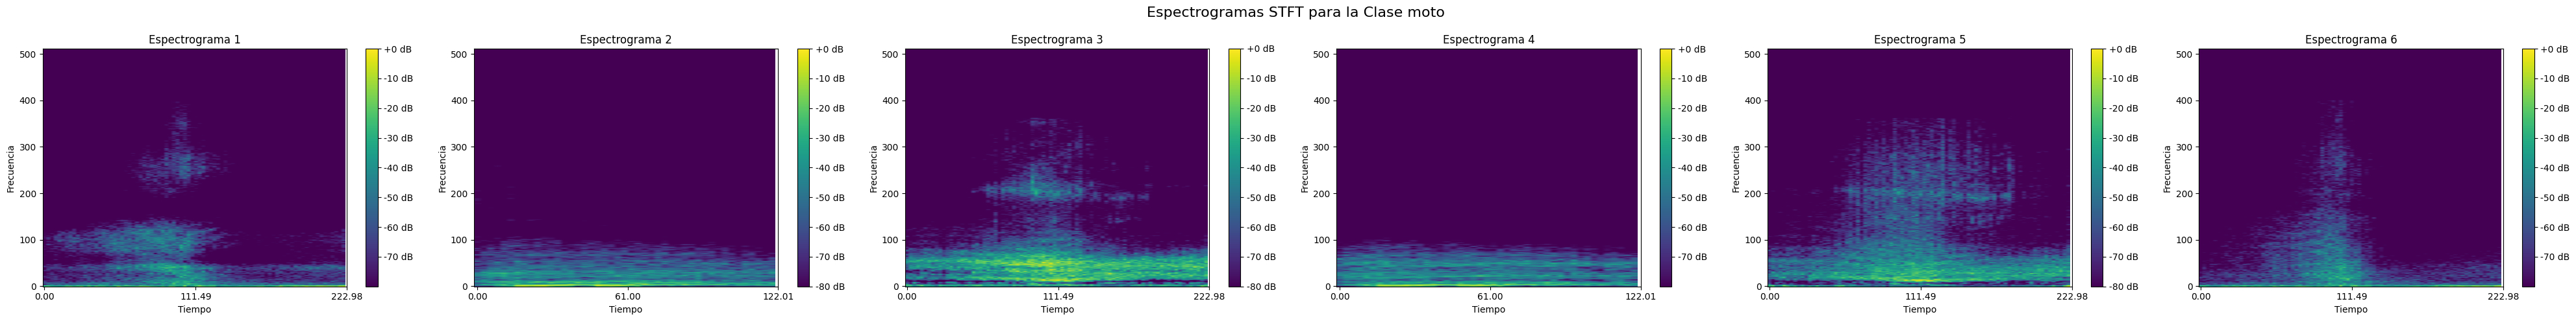

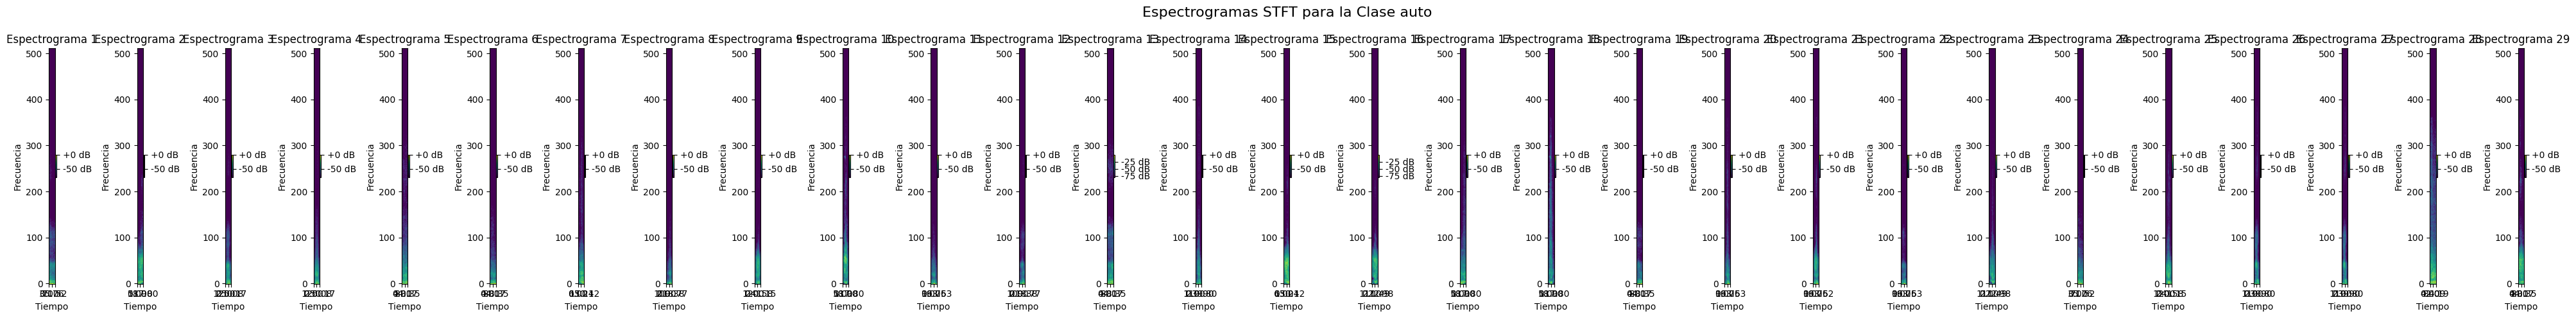

<ipython-input-214-e9fec3935c75>:24: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


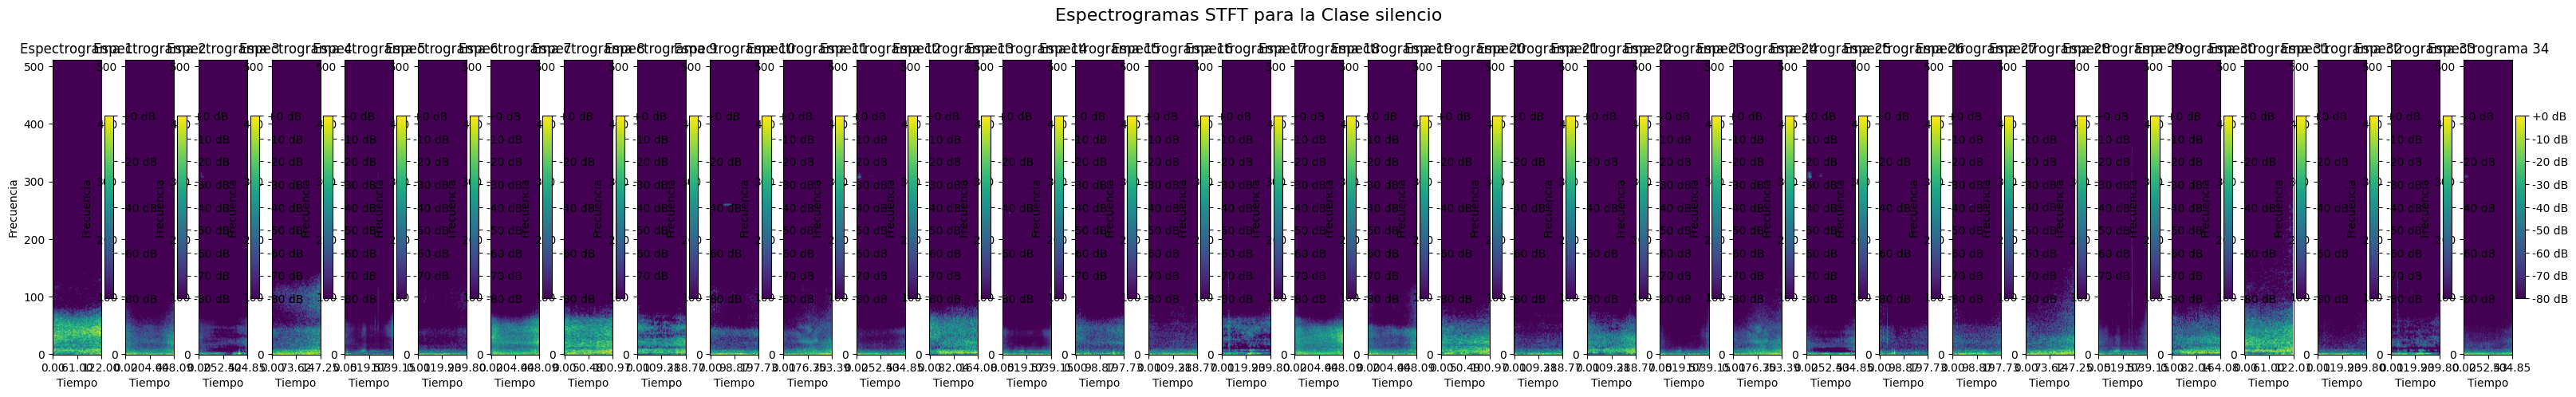

In [214]:
# Función para graficar los espectrogramas STFT de una clase específica
def plot_stft_spectrograms(stft_spectrograms, class_name, sr):
    num_specs = len(stft_spectrograms[class_name])
    fig, axs = plt.subplots(1, num_specs, figsize=(40, 5))
    fig.suptitle(f'Espectrogramas STFT para la Clase {class_name}', fontsize=16)

    for i, stft_spec in enumerate(stft_spectrograms[class_name]):
        img = axs[i].imshow(stft_spec, cmap='viridis', origin='lower', aspect='auto')
        axs[i].set_title(f'Espectrograma {i + 1}')
        axs[i].set_xlabel('Tiempo')
        axs[i].set_ylabel('Frecuencia')

        # Calcular marcas de tiempo
        num_time_bins = stft_spec.shape[1]
        duration = len(data[class_name][i]) / sr
        time_ticks = np.linspace(0, duration, num_time_bins)

        # Configurar las marcas de tiempo en el eje x
        axs[i].set_xticks(np.linspace(0, num_time_bins, 3))
        axs[i].set_xticklabels([f'{t:.2f}' for t in np.linspace(0, duration, 3)])

        fig.colorbar(img, ax=axs[i], format='%+2.0f dB')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustar el espacio para el título
    plt.show()

# Graficar los espectrogramas STFT para cada clase
for class_name in stft_spectrograms.keys():
    plot_stft_spectrograms(stft_spectrograms, class_name, sampling_rate)

In [210]:
# poniendo todos los datos como una lista
train_x = []
labels = []
for k in stft_spectrograms.keys(): #spects
    for s in stft_spectrograms[k]: #spects
        train_x.append(s) #s[2]
        labels.append([k])

In [211]:
#obtener mayor longiud para recortar espectogramas
may=train_x[0].shape[1]
for i in range (1,len(train_x)):
  if (train_x[i].shape[1]>may):
    may=train_x[i].shape[1]
print(may)

381


In [212]:
print(train_x[1].shape)
print(np.pad(train_x[1], ((0, 0), (0, may - train_x[1].shape[1])), mode='constant').shape )

(512, 182)
(512, 381)


In [213]:
#poner todos los espectogramas del mismo largo rellenando con 0's
train=[]
for i in range (len(train_x)):
  tam=train_x[i].shape[1]
  if (tam!=may):
    train.append(np.pad(train_x[i], ((0, 0), (0, may - train_x[i].shape[1])), mode='constant'))
  else:
    train.append(train_x[i])

#Codificar los tipos de clases
Lo haremos con el tipo _One-Hot encoding_

In [215]:
from sklearn.preprocessing import LabelEncoder

In [216]:
print(labels)

[['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['colectivo'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['camioneta'], ['moto'], ['moto'], ['moto'], ['moto'], ['moto'], ['moto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['auto'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['silencio'], ['sil

In [217]:
# Creamos el encoder
enc = LabelEncoder()
# transformamos y tenemos nuestros ground truth
train_y = enc.fit_transform(labels).reshape(-1,1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [121]:
print(train_y)

[[2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]]


#Crear Modelo Combinado: CNN + LSTM

Definir modelo

In [2]:
# Definimos un modelo
class CNN_LSTM(torch.nn.Module):
    def __init__(self, num_f,num_c,n_out):
        super().__init__()
        #********CNN********#
        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=32,
                                     kernel_size=(3,3),
                                     padding = (1,1),
                                     stride = (1,1)
                                     )
        self.drop = torch.nn.Dropout(0.3)
        # 32, 201*111
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=(2,2))
        # 32, achica en 2 la dimensión
        self.conv2 = torch.nn.Conv2d(in_channels = 32,
                                     out_channels=64,
                                     kernel_size=(3,3),
                                     stride=(1,1),
                                     padding=(1,1)
                                     )
        # 64, misma dimesión despues de max pool
        self.act2  = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=(2,2))
        #64, achica en 2 la dimensión
        self.lin   = torch.nn.Linear(in_features = 64*(num_f//4)*(num_c//4),
                                     out_features = 32)
        #********LSTM********#
        self.lstm = torch.nn.LSTM(input_size  = 32,
                                  hidden_size = 256,
                                  num_layers  = 5,
                                  batch_first = True,
                                  bidirectional= True)
        self.fcon = torch.nn.Linear( in_features  = 4* 128, #se multiplica por 2 por ser bidireccional
                                     out_features = n_out)


    def forward(self, x):
        #********CNN********#
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop(x)
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop(x)
        x = x.flatten(0)
        x = self.lin(x)
        #********LSTM********#
        x= x[None,None,:]
        x, _ = self.lstm(x)
        x = self.fcon(x)
        return x[:,-1,:].squeeze(1) # regresamos el ultimo valor (many to one)

NameError: name 'torch' is not defined

Instanciar modelo

In [235]:
#Como todos loes espectogramas tienen la misma dimensión, tomamos las
#dimensiones del primero para crear el modelo
num_f=train[0].shape[0]
num_c=train[0].shape[1]
cmodel = CNN_LSTM(num_f,num_c,len(stft_spectrograms.keys())).to(device)

Probar que el modelo no tenga errores de definición

In [236]:
pred=cmodel(torch.from_numpy(train[12].reshape(1,num_f,num_c)).float().to(device))

In [237]:
print(pred)

tensor([[ 0.0424, -0.0197,  0.0331, -0.0040,  0.0094]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)


Entrenar Modelo

In [238]:
# Loss function y optimizador
criterion = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(cmodel.parameters(), lr = 0.0001)
hist = []

In [ ]:
for epochs in range(1000):
  cum = 0
  for i in range(len(train)):
    x=torch.unsqueeze(torch.from_numpy(train[i]).float(),0).to(device)
    y=torch.LongTensor(train_y[i]).to(device)
    ypred = cmodel(x)
    loss = criterion(ypred, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    cum += loss.item()
  print(cum)
  hist.append(cum)
plt.semilogy(hist)

150.05474269390106
162.4697334766388
139.6309549510479
170.7696511745453
151.800595164299
150.87994515895844
149.50282633304596
149.99973106384277
148.98909783363342
147.45735108852386
147.14184296131134
146.6281065940857
146.47295033931732
145.87352073192596
145.99476671218872
145.69358432292938
145.6185274720192
138.91337630152702
159.35191142559052
135.85237856209278
146.46466636657715
160.1497448682785
153.18329966068268
148.13696563243866
147.1802817583084
146.30819404125214
145.52989828586578
144.7464039325714
144.36189448833466
144.48350143432617
143.79267370700836
143.2965218424797
147.1337720155716
142.66447359323502
146.7907292842865
143.12842428684235
138.0540024638176
146.66111761331558
137.98025351762772
132.6849736571312
130.32521383464336
134.81722486019135
127.18040576577187
128.82450383901596
127.52902403473854
126.83934956789017
126.56596544384956
126.07183015346527
125.8936137855053
125.4881300330162
125.40246751904488
125.0647951066494
124.91157299280167
124.6609720